**Section 6 – Processing Status: What Is the Final Outcome?**

In this section, we examine the final status of each insurance claim to assess the efficiency and quality of the claims handling process. Specifically, we focus on determining whether claims are being approved, rejected, or remain pending, and how these outcomes vary across different dimensions.

🔹 Objective:
To monitor and evaluate the final resolution of claims and identify patterns or inefficiencies in the approval workflow.

🔹 Key Research Questions:

What proportion of claims are rejected?

How common is the “pending” status?

This analysis supports quality control in the claim handling process by identifying rejection trends, uncovering delays, and providing insights into broker performance. Understanding these patterns allows for better decision-making and process optimization aimed at reducing wait times and improving claim resolution outcomes.

**1. Download Data from excel file**

🔹 Dataset Utilized:
Claims Announcements

🔹The "Claims Announcements" dataset contains detailed records of insurance claims that have been reported. Each row represents an individual claim and includes the following key information:

 + IDs: Claim, policy, broker, insured, and product identifiers

 + Dates: Event, announcement, and closing dates

 + Financials: Last forecasted payout amount

In [22]:
#Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import openpyxl
from datetime import datetime

In [14]:
# Load the Excel file
file_path = "D:/OCode/Big data analysis/Cleaned_Insurance_Claims_Data.xlsx"
excel_data = pd.ExcelFile(file_path)

# Load the "Claims Announcements" sheet as this is the data we need
claims_df = pd.read_excel(file_path, sheet_name='Claims Announcements')

# Show the first few rows to inspect the structure
claims_df.head()

,ClaimID,ClaimCode,PolicyID,PolicyCode,AnnouncementDate,EventDate,ClosingDate,LastForecastAmount,BrokerID,InsuredID,ProductID
0,385398,Clm-385398,807778,Pol-807778,2018-05-22,2018-05-19,2018-08-30,25296.46,394,386585,58
1,340182,Clm-340182,807800,Pol-807800,2017-10-20,2017-10-10,2017-11-20,3700.00,394,19191,58
2,418588,Clm-418588,807800,Pol-807800,2018-11-05,2018-11-02,2019-05-20,257.24,394,19191,58
3,471930,Clm-471930,807800,Pol-807800,2019-06-03,2019-05-29,2020-03-04,11062.23,394,19191,58
4,516031,Clm-516031,807800,Pol-807800,2019-11-27,2019-10-11,2019-12-10,500.00,394,19191,58


**2. Identify the variable representing claim status**

Calculate processing time = ClosingDate - AnnouncementDate

Standardize claim statuses into the following groups:
 + If ClosingDate is missing or later than today, it's "Pending".

 + If LastForecastAmount is 0, it's "Rejected".

 + Otherwise, it's "Approved".

In [35]:
# Convert date columns
claims_df['AnnouncementDate'] = pd.to_datetime(claims_df['AnnouncementDate'])
claims_df['ClosingDate'] = pd.to_datetime(claims_df['ClosingDate'])

# Define today's date
today = pd.Timestamp(datetime.today().date())

# Define status classification function
def classify_status(row):
    if pd.isna(row['ClosingDate']) or row['ClosingDate'] > today:
        return 'Pending'
    elif row['LastForecastAmount'] == 0:
        return 'Rejected'
    else:
        return 'Approved'

# Apply classification
claims_df['Status'] = claims_df.apply(classify_status, axis=1)

# Calculate processing time in days
claims_df['ProcessingTime'] = (claims_df['ClosingDate'] - claims_df['AnnouncementDate']).dt.days

# Show count of each status
print(claims_df['Status'].value_counts())

Status
Approved    10536
Pending      3176
Name: count, dtype: int64


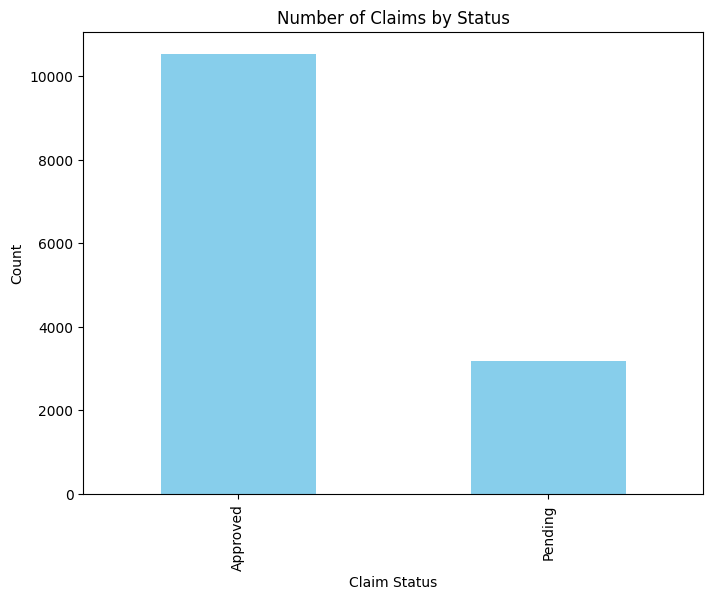

In [ ]:
claims_df['Status'].value_counts().plot(kind='bar', color='skyblue', figsize=(8, 6))
plt.title('Number of Claims by Status')
plt.xlabel('Claim Status')
plt.ylabel('Count')
plt.show()

**Result**

After processing the data, we classified a total of 13,712 insurance claims into two main statuses:

✅ Approved: 10,536 claims.
These are claims that were successfully processed and had a positive forecasted payout.

⏳ Pending: 3,176 claims.
These are still being processed, indicated by a ClosingDate in the future. They may not have reached a final decision yet.

❌ Rejected: 0 claims.
No claims in the dataset met the criteria of having LastForecastAmount = 0 with a valid ClosingDate.

**Insights:**

A large majority (≈77%) of claims have been approved.

A significant portion (≈23%) are still pending, which may suggest processing delays or recent submissions.

The absence of rejected claims could either reflect high approval rates or incomplete rejection data (e.g., if rejection is handled outside this system or recorded differently).

**3. Visualize the data**

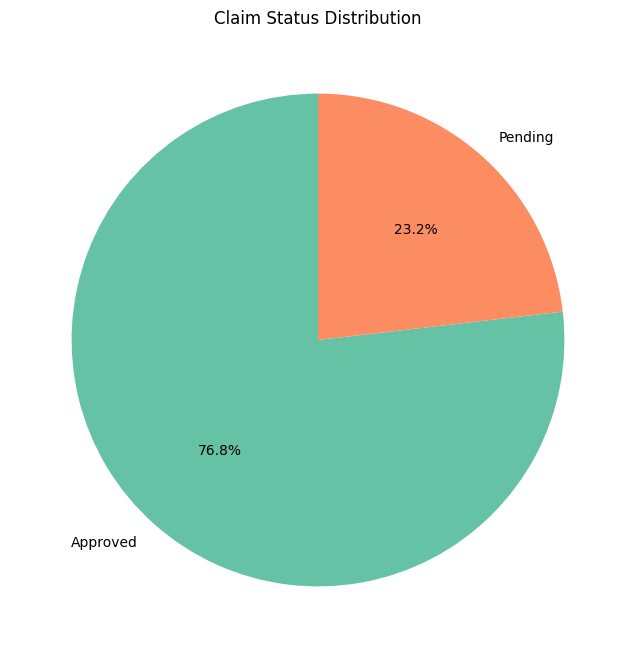

In [ ]:
# 1. Status Pie Chart
status_counts = claims_df['Status'].value_counts()
plt.figure(figsize=(8, 8))
status_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Claim Status Distribution')
plt.ylabel('')
plt.show()

1. Description:

The pie chart illustrates the distribution of claim statuses in the dataset. It shows the proportion of claims that are Approved and Pending:


 + Approved Claims: Represent 76.8% of the total claims.
 + Pending Claims: Represent 23.2% of the total claims.

2. Analysis Insights:
 + High Approval Rate: The majority of claims (≈77%) have been successfully processed and approved, indicating an efficient claims handling process for most cases.
 + Pending Claims: A significant portion (≈23%) of claims are still pending. This could indicate:
    + Recent submissions that are still under review.
    + Potential delays in processing due to systemic inefficiencies or resource constraints.
 + Focus Area: The pending claims should be analyzed further to identify bottlenecks, such as:
    + Specific brokers or regions with higher pending rates.
    + Claims with unusually long processing times.

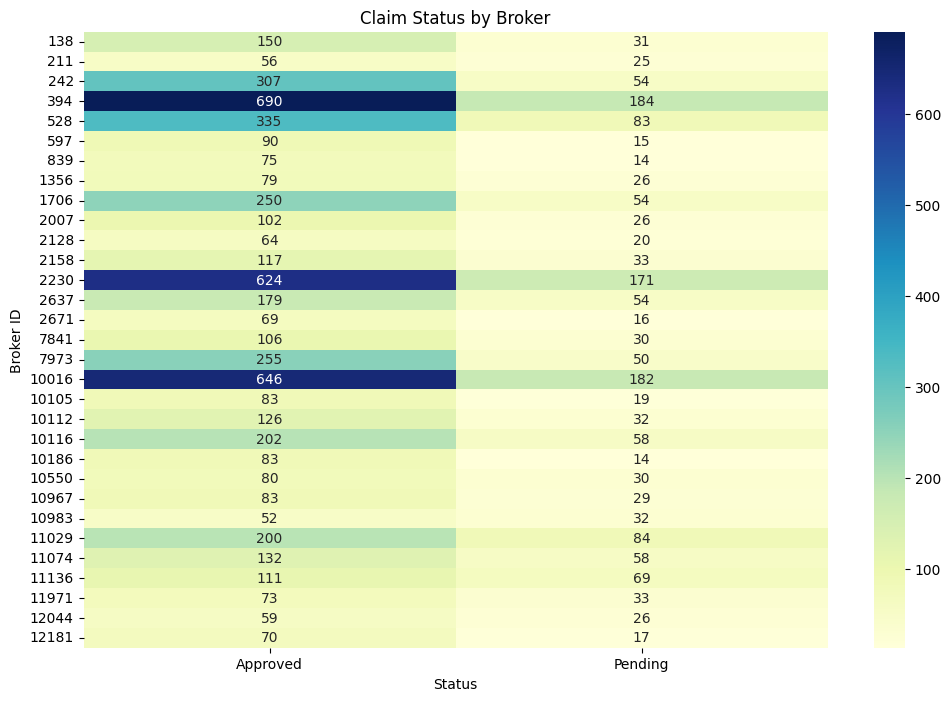

In [47]:
#2. Heatmap Claim Status by Broker
# Group brokers with fewer claims into "Other" to reduce clutter
broker_claim_counts = claims_df['BrokerID'].value_counts()
threshold = 80  # Minimum number of claims to display a broker
filtered_brokers = broker_claim_counts[broker_claim_counts >= threshold].index

# Filter the dataset to include only brokers with sufficient claims
filtered_claims_df = claims_df[claims_df['BrokerID'].isin(filtered_brokers)]

# Create the heatmap
broker_status = filtered_claims_df.pivot_table(index='BrokerID', columns='Status', aggfunc='size', fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(broker_status, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Claim Status by Broker')
plt.xlabel('Status')
plt.ylabel('Broker ID')
plt.show()

1. Description:

The heatmap visualizes the distribution of **Approved** and **Pending** claims across different brokers. Each row represents a broker, and the intensity of the color indicates the number of claims in each status. Darker shades represent higher claim counts, while lighter shades represent lower counts.

2. Analysis Insights:
+ High Variability Among Brokers:

    + Some brokers, such as Broker IDs 394, 2230, and 10016, have significantly higher claim volumes compared to others.
    + These brokers handle a large number of both **Approved** and **Pending** claims, indicating their central role in the claims process.
+ Pending Claims Concentration:

    + Brokers like 2230 and 10016 have a noticeable number of **Pending** claims, which could indicate potential bottlenecks or delays in processing.
+ Efficient Brokers:

    + Brokers such as 138, 211, and 10105 have relatively fewer Pending claims compared to their **Approved** claims, suggesting efficient claim handling.


C:\Users\nguye\AppData\Local\Temp\ipykernel_10224\1872703087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  approved_claims['ProcessingTimeYears'] = approved_claims['ProcessingTime'] / 365
C:\Users\nguye\AppData\Local\Temp\ipykernel_10224\1872703087.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=approved_claims, x='Status', y='ProcessingTimeYears', palette=['#66c2a5'])


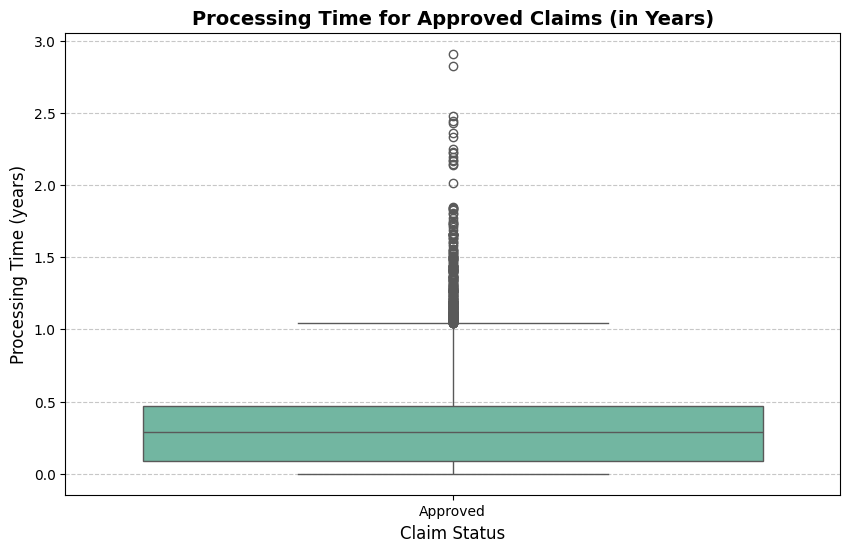

In [49]:
#3. Time Boxplot for Approved Claims
# Filter the dataset for only "Approved" claims
approved_claims = claims_df[claims_df['Status'] == 'Approved']

# Convert ProcessingTime from days to years
approved_claims['ProcessingTimeYears'] = approved_claims['ProcessingTime'] / 365

# Draw the boxplot for "Approved" claims
plt.figure(figsize=(10, 6))
sns.boxplot(data=approved_claims, x='Status', y='ProcessingTimeYears', palette=['#66c2a5'])
plt.title('Processing Time for Approved Claims (in Years)', fontsize=14, fontweight='bold')
plt.xlabel('Claim Status', fontsize=12)
plt.ylabel('Processing Time (years)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

1. Description:
The boxplot visualizes the Processing Time for Approved Claims in years. It shows the distribution of processing times for claims that have been approved, highlighting the median, interquartile range (IQR), and outliers.

 + Median Processing Time: The middle line in the box represents the median processing time.
 + Interquartile Range (IQR): The box spans the 25th to 75th percentiles, showing the range where most claims fall.
 + Outliers: Points above the whiskers represent claims with unusually long processing times.

2. Analysis Insights:
+ Efficient Processing: The majority of approved claims are processed in less than 0.5 years (approximately 6 months), as indicated by the median.
+ Outliers: A small number of claims take significantly longer to process, with some exceeding 2 years. These outliers may indicate:
    + Complex cases requiring additional review.
    + Delays caused by systemic inefficiencies or missing information.
+ Distribution:

    + The whiskers extend to approximately 1 year, suggesting that most claims are resolved within this timeframe.
    + The presence of outliers highlights the need to investigate specific cases to identify and address bottlenecks.


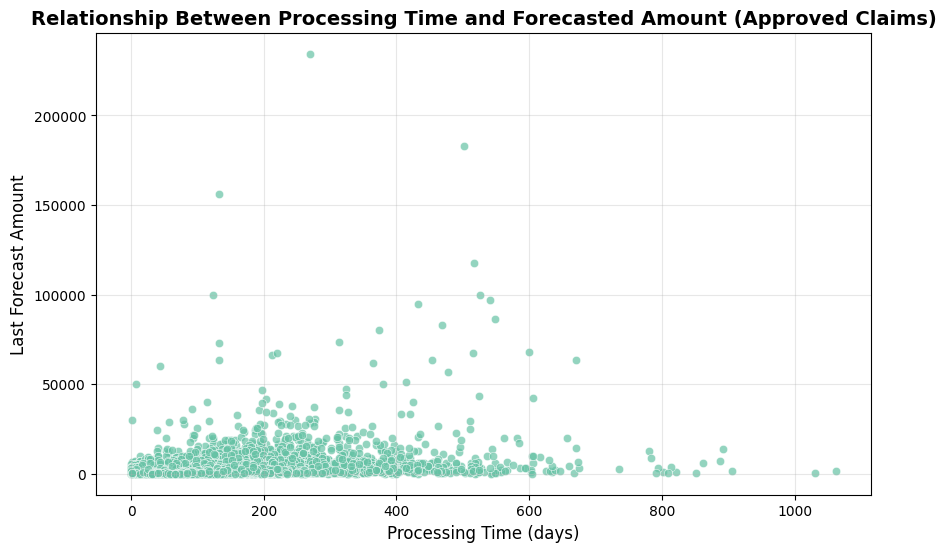

In [ ]:
#4. Scatter Plot showing relationship between Processing Time and Last Forecast Amount for Approved Claims
# Filter the dataset for only "Approved" claims
approved_claims = claims_df[claims_df['Status'] == 'Approved']

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=approved_claims, 
    x='ProcessingTime', 
    y='LastForecastAmount', 
    alpha=0.7, 
    color='#66c2a5'
)

# Add chart details
plt.title('Relationship Between Processing Time and Forecasted Amount (Approved Claims)', fontsize=14, fontweight='bold')
plt.xlabel('Processing Time (days)', fontsize=12)
plt.ylabel('Last Forecast Amount', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

1. Description:
The scatter plot visualizes the relationship between Processing Time (in days) and Last Forecast Amount (forecasted payout) for approved claims. Each point represents an individual approved claim, with its position determined by the processing time and forecasted payout amount.

+ X-axis: Processing Time (days) – the time taken to process the claim.
+ Y-axis: Last Forecast Amount – the forecasted payout amount for the claim.
2. Analysis Insights:
+ Concentration of Claims:

    + The majority of claims are processed within 200 days, with forecasted payouts below 50,000.
    + This indicates that most claims are resolved relatively quickly and involve smaller payouts.
+ High Payout Claims:

    + A few claims with forecasted payouts exceeding 100,000 are visible, but they are rare.
    + These high-payout claims tend to have longer processing times, suggesting that larger payouts may require more thorough review or additional steps.
+ Outliers:

    + There are some claims with extremely high forecasted payouts (e.g., above 200,000) and longer processing times (e.g., over 600 days). These outliers may represent complex or exceptional cases.
+ No Strong Correlation:

    + The scatter plot does not show a clear linear relationship between processing time and forecasted payout. This suggests that processing time is not strongly influenced by the payout amount.